In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph

# Planning:

- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### BUGS:
- urgent: logdet calculation gives Nans, current fix: replace the zeros by eye in the sparse add, does not solve it in any case however

-> try: does it work with decomp and I stabilizer?

- m and S values go to infinity if inducing_point_res >= 9


### TODOS:
- optimize Lookup Table resolution (Max)
- Check T region definition (currently limits of inducing points)
- calculate and print lower bound for testset
- improve 2d sampling function

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

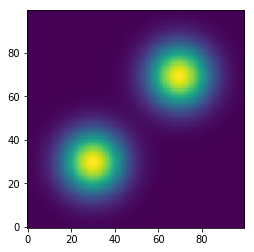

In [3]:
res = 100

Tmin = 0
Tmax = 10

xx, yy = np.meshgrid(np.linspace(Tmin, Tmax, res), np.linspace(Tmin, Tmax, res))

X = np.array([xx, yy]).transpose(1,2,0).reshape(res**2, 2)
vals = double_blob(X).reshape(res,res)

plt.imshow(vals, interpolation='none', origin='lower')
plt.show()

In [4]:
samples, _, _, _ = get_scp_samples(double_blob, np.array([[Tmin, Tmax], [Tmin,Tmax]]), 10)

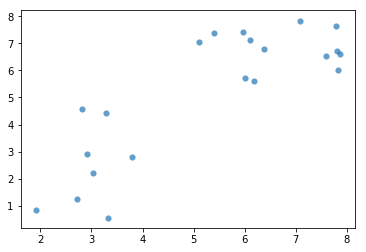

In [5]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

### 2D Parameter Learning

In [6]:
def train_paramters(res_inducing_points, alpha_init, data):
    ## ######## ##
    # PARAMETERS #
    ## ######## ##
    log_dir        = 'logs'
    max_iterations = 100
    ind_point_res  = res_inducing_points
    learning_rate  =0.01
    g_init = 0.3

    run_prefix = '2d_dummy_{}ipres_lr{}_{}iterations'.format(ind_point_res, learning_rate, max_iterations)

    # inducing point location
    Zx = np.linspace(1, 9, ind_point_res)[:,na]
    Zy = np.linspace(1, 9, ind_point_res)[:,na]

    xx_ind_points, yy_ind_points = np.meshgrid(Zx, Zy)

    Z = np.array([xx_ind_points, yy_ind_points]).transpose(1,2,0).reshape(ind_point_res**2, 2)

    # X = np.random.rand(10,2)*10

    ## ######### ##
    # BUILD GRAPH #
    ## ######### ##
    tf.reset_default_graph()
    lower_bound, merged, Z_ph, u_ph, X_ph, m, S,L_vech, interesting_gradient, K_zz_inv,a,g,Kzz = build_graph(Z.shape[0],Z.shape[1],alpha_init,g_init)

    with tf.name_scope('optimization'):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(-lower_bound,var_list=[m,L_vech,a,g])


    #inspected_op = tf.get_default_graph().get_tensor_by_name("KL-divergence/truediv:0")
    #interesting_gradient = tf.gradients(lower_bound, [inspected_op])[0]

    check = tf.add_check_numerics_ops()

    ## ########## ##
    # OPTIMIZATION #
    ## ########## ##
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter(log_dir + '/' + run_prefix, sess.graph)

        S_init_val = sess.run([S])
        # print(S_init_val)
        # print(np.all(np.linalg.eigvals(S_init_val) >= 0))

        for i in range(max_iterations):
            _, lower_bound_val, m_val, S_val, grad_val, summary, Kzz_inv, _,a_vals,g_val,Kzz_val = sess.run([train_step, lower_bound, m, S, interesting_gradient, merged, K_zz_inv, check,a,g,Kzz], feed_dict={Z_ph:Z, u_ph:0.,X_ph:data})
            writer.add_summary(summary, i)

            # print('------------')
            #print(lower_bound_val)
            #print(Kzz_val)
            #print(g_val)
            # print(np.min(S_val))
            # print(np.max(S_val))
            # print(np.allclose(S_val, S_val.T))
            # print(np.all(np.linalg.eigvals(S_val) >= 0))

            #print(sess.run([S]))
            #print(sess.run([L_vech_grad]))
    return m_val, S_val, Kzz_inv, a_vals, Z,g_val

#### 2D Evaluation

In [7]:
def evaluation(m_val,S_val,Kzz_inv,a_vals,g_val,Z,eval_grid):   
    #build graph
    lam, lam_var, Z_ph,X_eval_ph, K_zz_inv_ph, S_ph, m_ph,a_ph,g_ph  = build_eval_graph()

    #run session
    with tf.Session() as sess:
        lam_vals, = sess.run([lam], feed_dict={Z_ph:Z, X_eval_ph:eval_grid,K_zz_inv_ph: Kzz_inv,S_ph:S_val,m_ph:m_val,a_ph:a_vals,g_ph:g_val})

    return lam_vals


#### Evaluation with learned alphas and increasing number of inducing points

number inducing points:  2
alphas:  [ 21.88575745  21.82249451]
gamma:  -12.3565


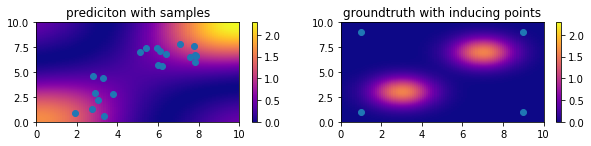

number inducing points:  3
alphas:  [ 10.11708069   9.88387299]
gamma:  -0.866934


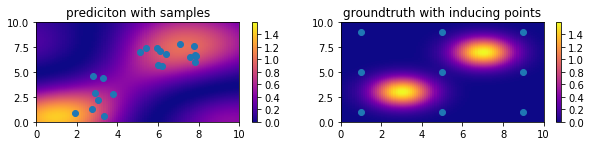

number inducing points:  4
alphas:  [ 8.4138813  8.591115 ]
gamma:  3.73302


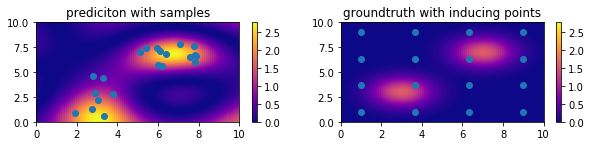

number inducing points:  5
alphas:  [ 3.57649398  3.50288367]
gamma:  0.457725


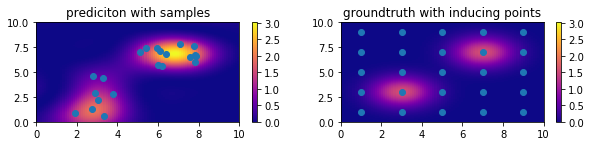

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: KL-divergence/logdet/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ard_kernel/mul_1)]]

Caused by op 'KL-divergence/logdet/Cholesky', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-dd4d06bcf24a>", line 15, in <module>
    m_opt, S_opt, Kzz_inv_opt, a_opt, Z_opt,g_opt = train_paramters(i,1, samples)
  File "<ipython-input-6-dcb08b1c2946>", line 27, in train_paramters
    lower_bound, merged, Z_ph, u_ph, X_ph, m, S,L_vech, interesting_gradient, K_zz_inv,a,g,Kzz = build_graph(Z.shape[0],Z.shape[1],alpha_init,g_init)
  File "/home/lea/Schreibtisch/TUB/WS17/KI-Projekt/pmai-vi-gpmpp/utils.py", line 91, in build_graph
    kl_term_op = kl_term(m, S, K_zz, K_zz_inv, u_ph, L)
  File "/home/lea/Schreibtisch/TUB/WS17/KI-Projekt/pmai-vi-gpmpp/utils.py", line 151, in kl_term
    K_zz_logdet = tf.linalg.logdet(K_zz)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/ops/linalg_impl.py", line 53, in logdet
    chol = gen_linalg_ops.cholesky(matrix)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 420, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: KL-divergence/logdet/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ard_kernel/mul_1)]]


In [8]:
#evaluation grid
  
eval_res = 100
eval_x = np.linspace(Tmin, Tmax, eval_res)[:,na]
eval_y = np.linspace(Tmin, Tmax, eval_res)[:,na]
xx_eval, yy_eval = np.meshgrid(eval_x, eval_y)
eval_grid = np.array([xx_eval, yy_eval]).transpose(1,2,0).reshape(eval_res**2, 2)

num_iterations = 7
counter = 1


for i in np.arange(2,7): 
    
    m_opt, S_opt, Kzz_inv_opt, a_opt, Z_opt,g_opt = train_paramters(i,1, samples)
    lam_vals = evaluation(m_opt,S_opt,Kzz_inv_opt,a_opt,g_opt,Z_opt,eval_grid)

    #plots
    cmap = plt.get_cmap('plasma')

    fig = plt.figure(figsize=(10,15)) 

    max_value = np.max([np.max(vals), np.max(lam_vals)])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

    print("number inducing points: ",i)
    print("alphas: ",a_opt)
    print("gamma: ",g_opt)
    ax0 = ax0 = plt.subplot(num_iterations,2,counter)
    im = ax0.pcolormesh(xx_eval, yy_eval, lam_vals.reshape(eval_res,eval_res), cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('prediciton with samples')
    ax0.scatter(samples[:,0], samples[:,1])
    plt.xlim(Tmin, Tmax)
    plt.ylim(Tmin, Tmax)

    ax1 = ax0 = plt.subplot(num_iterations,2,counter+1)
    im1 = ax1.pcolormesh(xx, yy, vals, cmap=cmap, norm=norm)
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('groundtruth with inducing points')
    ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
    plt.xlim(Tmin, Tmax)
    plt.ylim(Tmin, Tmax)
    counter += 2
    #plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
    plt.show()
